In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.datasets import cifar10
from collections import Counter
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

### Reproducibility

In [2]:
SEED = 22
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Set class number to train for

In [3]:
KEEP_CLASS_NUMBER = 6

### General functions

In [4]:
def get_class_summary(y):
    y_flat = y.flatten() 
    counter = Counter(y_flat)
    return counter

In [5]:
def plot_distribution(class_counts):
    labels, counts = zip(*sorted(class_counts.items()))
    label_names = [class_names[label] for label in labels]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(x=label_names, y=counts)
    plt.title('Distribution of classes')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

In [6]:
def show_image_grid(X, y, rows, cols, figsize):
    # Create a new figure
    plt.figure(figsize=figsize)
  
    for i in range(rows*cols):
        plt.subplot(rows, cols, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i])
        plt.title(class_names[y[i][0]])
    
    plt.show()

#### CNN structure

In [7]:
def build_simple_cnn(input_shape=(32, 32, 3), num_classes=KEEP_CLASS_NUMBER):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # CNN Block 1
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    # CNN Block 2
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Dropout(0.25)(x)

    cnn_output = tf.keras.layers.Flatten(name='cnn_output')(x)

    # Dense layers
    dense_1 = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(cnn_output)
    dropout_1 = tf.keras.layers.Dropout(0.5)(dense_1)

    # Final layer (logits before softmax)
    logits = Dense(num_classes, name='logits')(dropout_1)
    outputs = tf.keras.layers.Softmax(name='softmax')(logits)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

#### Isolation forest

In [8]:
from sklearn.ensemble import IsolationForest

def fit_iso_forest(n_estimators, contamination, train_features, test_features):
    # Initialize the model
    iso_forest = IsolationForest(
        n_estimators=n_estimators,
        contamination=contamination,
        random_state=SEED
    )
    
    # Fit the model
    iso_forest.fit(train_features)
    
    # Predict anomalies (-1 = outlier, 1 = inlier)
    predictions = iso_forest.predict(test_features)
    
    # Get anomaly scores (the lower, the more anomalous)
    anomaly_scores = iso_forest.decision_function(test_features)

    return anomaly_scores, predictions

In [9]:
def get_outlier_stats(X, y, outlier_indices, anomaly_scores):
    X_outliers = X[outlier_indices]
    y_outliers = y[outlier_indices]
    scores = anomaly_scores[outlier_indices]
    df_outliers = pd.DataFrame({
        'label': y_outliers.flatten(),
        'score': scores
    })
    
    df_all = pd.DataFrame({
        'label': y_combined.flatten(),
        'score': anomaly_scores
    })
    
    # Group by label and compute mean score
    avg_scores_per_class = df_all.groupby('label')['score'].agg(
        mean_score='mean',
        min_score='min',
        max_score='max',
        std_score='std'
    ).reset_index()
    count_per_class = df_outliers.groupby('label')['score'].agg(
        count='count'
    ).reset_index()
    avg_scores_per_class['class_name'] = avg_scores_per_class['label'].apply(lambda x: class_names[x])
    count_per_class['class_name'] = count_per_class['label'].apply(lambda x: class_names[x])
    return avg_scores_per_class, count_per_class

In [10]:
def show_anomaly_score_plot(anomaly_scores):
    plt.hist(anomaly_scores, bins=50)
    plt.title("Anomaly Score Distribution")
    plt.xlabel("Score")
    plt.ylabel("Frequency")
    plt.show()

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
def print_evaluation_report(y_true, y_pred, target_names=['Unknown (OOD)', 'Known']):
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Outlier Detection Accuracy: {accuracy*100:.2f}%")

    print(classification_report(y_true, y_pred, target_names=target_names))
    cm = confusion_matrix(y_true, y_pred, labels=[-1, 1])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


# Load dataset from library

In [12]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [13]:
print('Train Images Shape:      ', X_train.shape)
print('Train Labels Shape:      ', y_train.shape)

print('\nTest Images Shape:       ', X_test.shape)
print('Test Labels Shape:       ', y_test.shape)

Train Images Shape:       (50000, 32, 32, 3)
Train Labels Shape:       (50000, 1)

Test Images Shape:        (10000, 32, 32, 3)
Test Labels Shape:        (10000, 1)


## CIFAR-10 classes

In [14]:
original_class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
class_names = ['bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'automobile', 'airplane']

In [15]:
CLASS_NUMBER = 10

## Remap labels for easier handling

In [16]:
label_mapping = {original_class_names.index(name): class_names.index(name) for name in original_class_names}

In [17]:
y_train_mapped = np.vectorize(label_mapping.get)(y_train)
y_test_mapped = np.vectorize(label_mapping.get)(y_test)

# Exclude 4 classes from training
Excluded class: airplane, automobile, truck, ship (last in list)

# Divide into trained and unknown classes

In [18]:
keep_classes = list(range(KEEP_CLASS_NUMBER))
other_classes = list(set(range(CLASS_NUMBER)) - set(range(KEEP_CLASS_NUMBER)))

# Masks
train_keep_mask = np.isin(y_train_mapped.flatten(), keep_classes)
test_keep_mask = np.isin(y_test_mapped.flatten(), keep_classes)

train_unknown_mask = np.isin(y_train_mapped.flatten(), other_classes)
test_unknown_mask = np.isin(y_test_mapped.flatten(), other_classes)

# Apply
X_train_filtered = X_train[train_keep_mask]
y_train_filtered = y_train_mapped[train_keep_mask]

X_test_filtered = X_test[test_keep_mask]
y_test_filtered = y_test_mapped[test_keep_mask]

X_train_unknown = X_train[train_unknown_mask]
y_train_unknown = y_train_mapped[train_unknown_mask]
X_test_unknown = X_test[test_unknown_mask]
y_test_unknown = y_test_mapped[test_unknown_mask]

In [19]:
print("Train labels and counts:", get_class_summary(y_train_filtered))
print("Test labels and counts:", get_class_summary(y_test_filtered))
print("Unknown train labels and counts:", get_class_summary(y_train_unknown))
print("Unknown test labels and counts:", get_class_summary(y_test_unknown))

Train labels and counts: Counter({4: 5000, 2: 5000, 0: 5000, 5: 5000, 1: 5000, 3: 5000})
Test labels and counts: Counter({1: 1000, 4: 1000, 3: 1000, 5: 1000, 2: 1000, 0: 1000})
Unknown train labels and counts: Counter({7: 5000, 8: 5000, 6: 5000, 9: 5000})
Unknown test labels and counts: Counter({6: 1000, 9: 1000, 8: 1000, 7: 1000})


# Plot class distribution

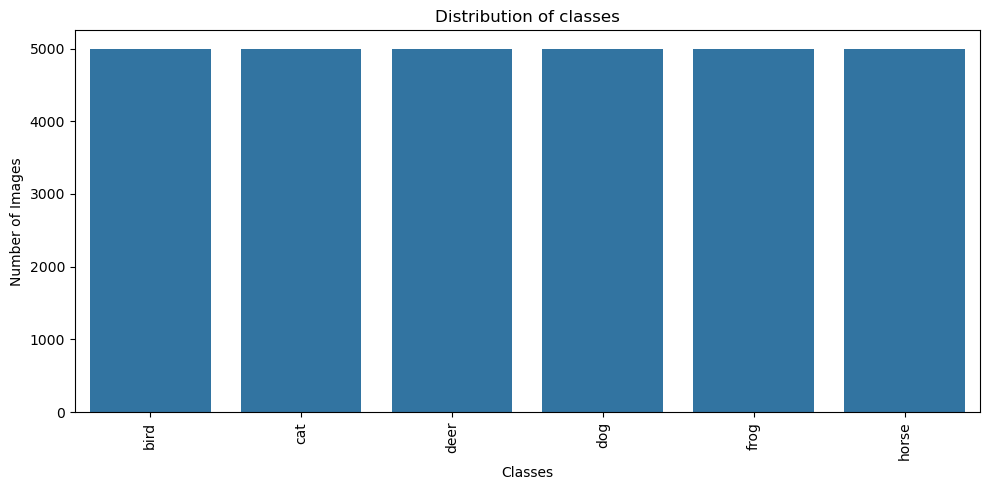

In [20]:
class_count =  get_class_summary(y_train_filtered)
plot_distribution(class_count)

# Examples

## Known classes

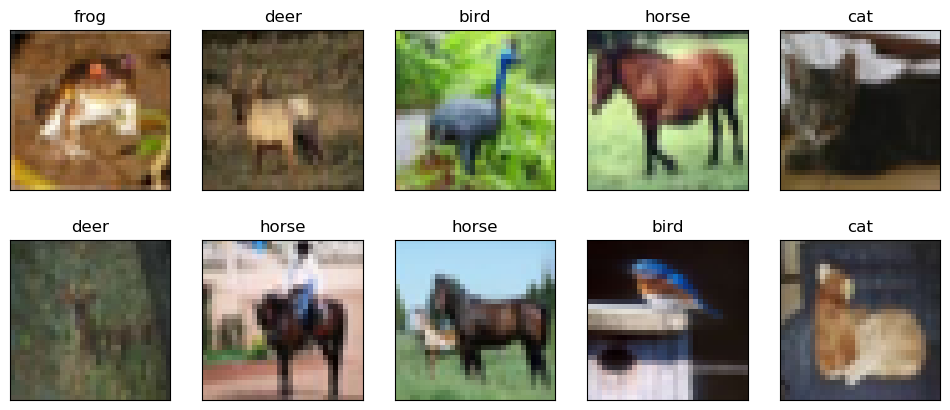

In [21]:
show_image_grid(X_train_filtered[:10], y_train_filtered[:10], 2, 5, (12,5))

## Unknown classes

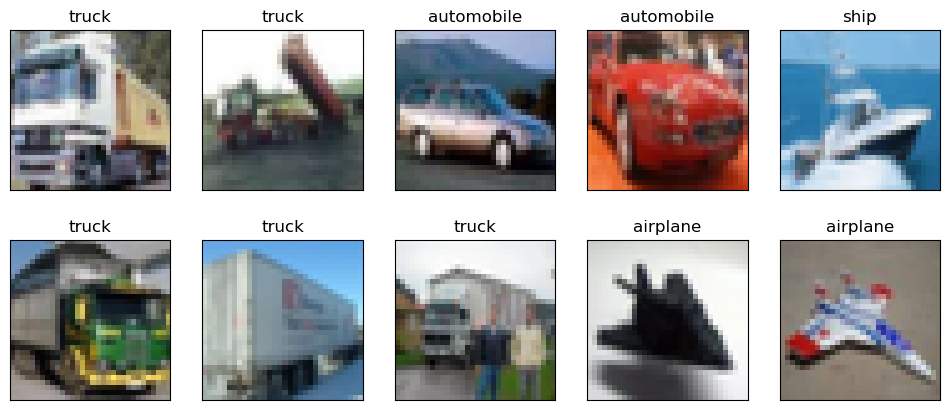

In [22]:
show_image_grid(X_train_unknown[:10], y_train_unknown[:10], 2, 5, (12,5))

# Preprocess images

## One-hot encoding of labels

In [23]:
enc = OneHotEncoder()
y_train_enc=enc.fit_transform(y_train_filtered).toarray().astype(int)
y_test_enc=enc.transform(y_test_filtered).toarray().astype(int)

## Flow generation

In [24]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [25]:
train_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='training'
)

val_flow = train_generator.flow(
    x=X_train_filtered,
    y=y_train_enc,
    batch_size=256,
    shuffle=True,
    seed=SEED,
    subset='validation'
)

test_flow = test_generator.flow(
    x=X_test_filtered,
    y=y_test_enc,
    batch_size=256,
    shuffle=False
)

# Fit simple CNN for classification

In [26]:
my_model = build_simple_cnn()

### Compile model

In [27]:
my_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

### Fit model

In [28]:
my_history = my_model.fit(
    train_flow,
    validation_data=val_flow,
    epochs=50,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
94/94 [==============================] - 48s 503ms/step - loss: 1.7408 - accuracy: 0.2973 - val_loss: 2.7163 - val_accuracy: 0.1665
Epoch 2/50
94/94 [==============================] - 48s 510ms/step - loss: 1.4700 - accuracy: 0.4127 - val_loss: 4.1421 - val_accuracy: 0.1730
Epoch 3/50
94/94 [==============================] - 48s 505ms/step - loss: 1.3540 - accuracy: 0.4710 - val_loss: 3.2542 - val_accuracy: 0.1742
Epoch 4/50
94/94 [==============================] - 49s 517ms/step - loss: 1.2770 - accuracy: 0.5046 - val_loss: 2.9446 - val_accuracy: 0.2055
Epoch 5/50
94/94 [==============================] - 43s 454ms/step - loss: 1.2034 - accuracy: 0.5350 - val_loss: 1.9926 - val_accuracy: 0.3480
Epoch 6/50
94/94 [==============================] - 42s 450ms/step - loss: 1.1427 - accuracy: 0.5615 - val_loss: 1.2257 - val_accuracy: 0.5245
Epoch 7/50
94/94 [==============================] - 42s 448ms/step - loss: 1.1025 - accuracy: 0.5776 - val_loss: 1.1336 - val_accuracy: 0.5768

### Save weights to skip training in the future

In [29]:
my_model.save_weights('models/my_model_weights_6_class.keras')

### Simply load saved weights

In [30]:
my_model.load_weights('models/my_model_weights_6_class.keras')

### Evaluate model

In [31]:
loss, accuracy = my_model.evaluate(test_flow, verbose=1)
print(f"Test accuracy: {accuracy*100:.2f}%, test loss: {loss:.4f}")

24/24 [==============================] - 3s 137ms/step - loss: 0.7999 - accuracy: 0.7195
Test accuracy: 71.95%, test loss: 0.7999


### Get intermediate models

In [32]:
# Model to get CNN output (flattened)
cnn_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('cnn_output').output)

# Model to get first Dense output
dense_output_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('dense_1').output)

# Model to get logits (before softmax)
logits_model = tf.keras.Model(inputs=my_model.input, outputs=my_model.get_layer('logits').output)

# Extract features using different layers of the CNN classifier

## Construct datasets for outlier search

### 10% contamination in training set: 4500 known, 500 unknown elements

In [33]:
# Step 1: Get 500 from unknown
X_unknown_subset, _, y_unknown_subset, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 500), random_state=SEED, shuffle=True
)

# Step 2: Get 4500 from filtered
X_filtered_subset, _, y_filtered_subset, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 4500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined = np.concatenate([X_filtered_subset, X_unknown_subset], axis=0)
y_combined = np.concatenate([y_filtered_subset, y_unknown_subset], axis=0)

In [34]:
X_combined.shape, y_combined.shape

((5000, 32, 32, 3), (5000, 1))

In [35]:
subset_train_flow = train_generator.flow(X_combined, y_combined, batch_size=256, shuffle=True, seed=SEED)

### Generate balanaced test data out of 2500 known and 2500 unknown samples

In [36]:
# Step 1: Get 2500 from unknown
X_unknown_subset_test, _, y_unknown_subset_test, _ = train_test_split(
    X_train_unknown, y_train_unknown, test_size=(len(X_train_unknown) - 2500), random_state=SEED, shuffle=True
)

# Step 2: Get 2500 from filtered
X_filtered_subset_test, _, y_filtered_subset_test, _ = train_test_split(
    X_train_filtered, y_train_filtered, test_size=(len(X_train_filtered) - 2500), random_state=SEED, shuffle=True
)

# Step 3: Combine
X_combined_test = np.concatenate([X_filtered_subset_test, X_unknown_subset_test], axis=0)
y_combined_test = np.concatenate([y_filtered_subset_test, y_unknown_subset_test], axis=0)

# Step 4: Create "known vs unknown" labels
is_known = np.concatenate([
    np.ones(len(X_filtered_subset_test)),   # known = 1
    -1 * np.ones(len(X_unknown_subset_test))  # unknown = -1
])

In [37]:
X_combined_test.shape, y_combined_test.shape

((5000, 32, 32, 3), (5000, 1))

In [38]:
subset_test_flow = train_generator.flow(X_combined_test, y_combined_test, batch_size=256, shuffle=False, seed=SEED)

## CNN as feature extractor

In [39]:
train_features_cnn = cnn_output_model.predict(subset_train_flow, verbose=1)
test_features_cnn =  cnn_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 4s 188ms/step


In [40]:
train_features_cnn.shape

(5000, 2048)

### Reduce feature number

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=256)
train_reduced_cnn = pca.fit_transform(train_features_cnn)
test_reduced_cnn = pca.fit_transform(test_features_cnn)

In [42]:
train_reduced_cnn.shape

(5000, 256)

### Fit isolation forest

In [43]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_cnn, 
    test_features = test_features_cnn
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 52.78%
               precision    recall  f1-score   support

Unknown (OOD)       0.62      0.14      0.23      2500
        Known       0.52      0.91      0.66      2500

     accuracy                           0.53      5000
    macro avg       0.57      0.53      0.45      5000
 weighted avg       0.57      0.53      0.45      5000



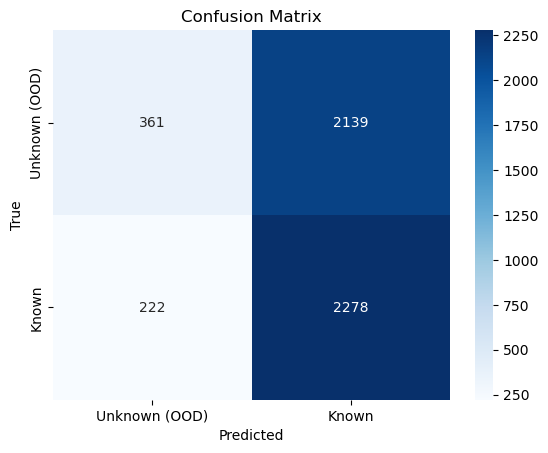

In [44]:
print_evaluation_report(is_known, predictions)

In [45]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.031479  -0.162982   0.092484   0.027618        bird
1      1    0.030638  -0.086968   0.084806   0.026596         cat
2      2    0.032812  -0.070962   0.097287   0.025571        deer
3      3    0.031508  -0.068861   0.085834   0.025715         dog
4      4    0.032016  -0.066053   0.091095   0.025203        frog
5      5    0.032784  -0.071634   0.087254   0.025978       horse
6      6    0.042180  -0.056348   0.084757   0.024885        ship
7      7    0.027975  -0.043672   0.070716   0.022246       truck
8      8    0.017801  -0.042436   0.066269   0.023115  automobile
9      9    0.030796  -0.037440   0.084077   0.024432    airplane


In [46]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     34        bird
1      1     38         cat
2      2     16        deer
3      3     41         dog
4      4     43        frog
5      5     50       horse
6      6     46        ship
7      7     78       truck
8      8    159  automobile
9      9     78    airplane


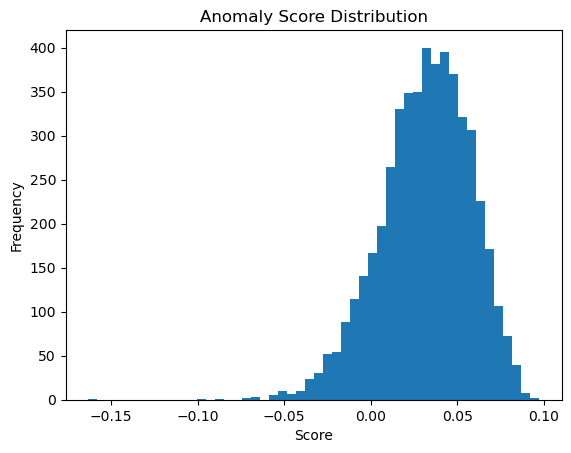

In [47]:
show_anomaly_score_plot(anomaly_scores)

## Dense layer features

In [48]:
train_features_dense = dense_output_model.predict(subset_train_flow, verbose=1)
test_features_dense =  dense_output_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 165ms/step


In [49]:
train_features_dense.shape

(5000, 128)

In [50]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_dense, 
    test_features = test_features_dense
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 45.82%
               precision    recall  f1-score   support

Unknown (OOD)       0.22      0.03      0.06      2500
        Known       0.48      0.88      0.62      2500

     accuracy                           0.46      5000
    macro avg       0.35      0.46      0.34      5000
 weighted avg       0.35      0.46      0.34      5000



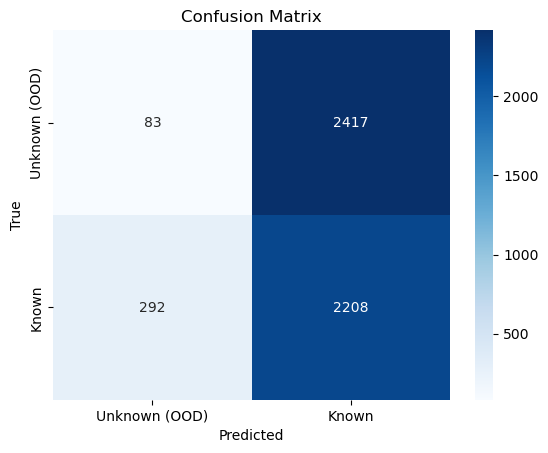

In [51]:
print_evaluation_report(is_known, predictions)

In [52]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.048786  -0.105580   0.093478   0.031690        bird
1      1    0.050896  -0.093510   0.095269   0.030753         cat
2      2    0.048989  -0.111961   0.095643   0.032400        deer
3      3    0.050077  -0.115535   0.093409   0.030819         dog
4      4    0.049970  -0.065958   0.094326   0.030181        frog
5      5    0.049034  -0.085169   0.093634   0.029374       horse
6      6    0.059251  -0.014306   0.094497   0.022942        ship
7      7    0.062825   0.009706   0.091302   0.016392       truck
8      8    0.068423  -0.029673   0.094188   0.018349  automobile
9      9    0.050253  -0.074125   0.091649   0.030469    airplane


In [53]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     52        bird
1      1     14         cat
2      2     47        deer
3      3     27         dog
4      4    109        frog
5      5     43       horse
6      6     18        ship
7      7      6       truck
8      8      3  automobile
9      9     56    airplane


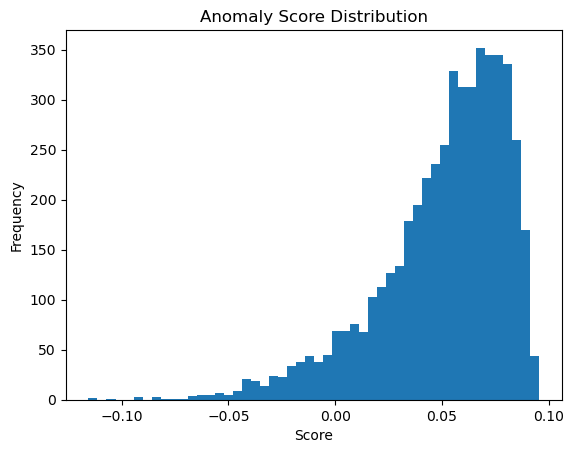

In [54]:
show_anomaly_score_plot(anomaly_scores)

## Logits

In [55]:
train_features_logits = logits_model.predict(subset_train_flow, verbose=1)
test_features_logits =  logits_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 4s 180ms/step


In [56]:
train_features_logits.shape

(5000, 6)

In [57]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features_logits, 
    test_features = test_features_logits
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 44.72%
               precision    recall  f1-score   support

Unknown (OOD)       0.06      0.01      0.01      2500
        Known       0.47      0.89      0.62      2500

     accuracy                           0.45      5000
    macro avg       0.26      0.45      0.31      5000
 weighted avg       0.26      0.45      0.31      5000



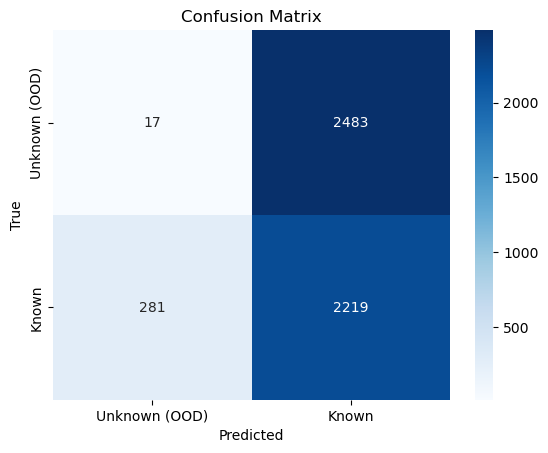

In [58]:
print_evaluation_report(is_known, predictions)

In [59]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.094787  -0.170945   0.159569   0.050074        bird
1      1    0.092212  -0.151303   0.153902   0.055577         cat
2      2    0.093058  -0.150619   0.155866   0.053875        deer
3      3    0.096837  -0.209976   0.156938   0.050654         dog
4      4    0.096487  -0.187449   0.153717   0.048535        frog
5      5    0.095051  -0.127639   0.153982   0.052627       horse
6      6    0.118826  -0.000467   0.153206   0.028649        ship
7      7    0.124646   0.042034   0.153743   0.021494       truck
8      8    0.121390   0.019527   0.153682   0.022452  automobile
9      9    0.103946  -0.072980   0.149045   0.040867    airplane


In [60]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     22        bird
1      1     23         cat
2      2     11        deer
3      3     53         dog
4      4    105        frog
5      5     67       horse
6      6      3        ship
7      8      1  automobile
8      9     13    airplane


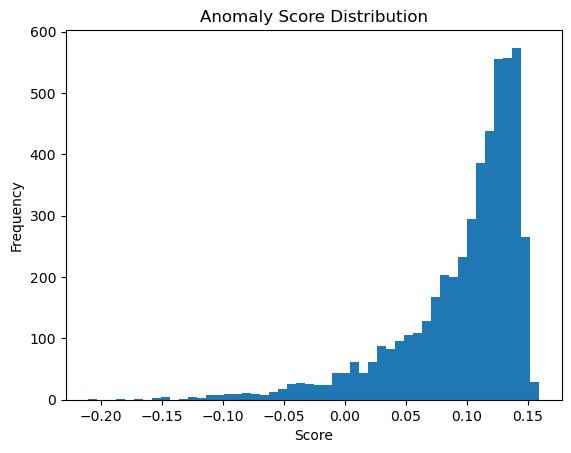

In [61]:
show_anomaly_score_plot(anomaly_scores)

## Model output

In [62]:
train_features = my_model.predict(subset_train_flow, verbose=1)
test_features =  my_model.predict(subset_test_flow, verbose=1)

20/20 [==============================] - 3s 167ms/step


In [63]:
train_features.shape

(5000, 6)

In [64]:
anomaly_scores, predictions = fit_iso_forest(
    n_estimators = 100, 
    contamination = 0.1, 
    train_features = train_features, 
    test_features = test_features
)
outlier_indices = np.where(predictions == -1)[0]
avg_scores_per_class, count_per_class = get_outlier_stats(X_combined_test, y_combined_test, outlier_indices, anomaly_scores)

### Display results

Outlier Detection Accuracy: 53.36%
               precision    recall  f1-score   support

Unknown (OOD)       0.62      0.17      0.27      2500
        Known       0.52      0.90      0.66      2500

     accuracy                           0.53      5000
    macro avg       0.57      0.53      0.46      5000
 weighted avg       0.57      0.53      0.46      5000



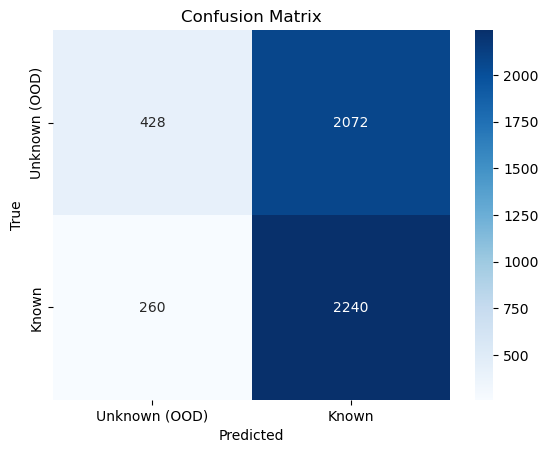

In [65]:
print_evaluation_report(is_known, predictions)

In [66]:
print("Global average anomaly scores")
print(avg_scores_per_class)

Global average anomaly scores
   label  mean_score  min_score  max_score  std_score  class_name
0      0    0.023839  -0.054192   0.083469   0.024181        bird
1      1    0.022627  -0.062413   0.083364   0.024390         cat
2      2    0.023205  -0.063574   0.083058   0.024040        deer
3      3    0.023834  -0.058215   0.084109   0.023405         dog
4      4    0.024136  -0.063378   0.083469   0.023596        frog
5      5    0.023770  -0.068112   0.084140   0.024069       horse
6      6    0.019363  -0.037726   0.047204   0.015037        ship
7      7    0.013649  -0.035811   0.059617   0.018552       truck
8      8    0.015871  -0.038057   0.076775   0.018749  automobile
9      9    0.018999  -0.029084   0.058045   0.015026    airplane


In [67]:
print("Outlier count")
print(count_per_class)

Outlier count
   label  count  class_name
0      0     54        bird
1      1     99         cat
2      2     28        deer
3      3     27         dog
4      4     20        frog
5      5     32       horse
6      6     78        ship
7      7    143       truck
8      8    141  automobile
9      9     66    airplane


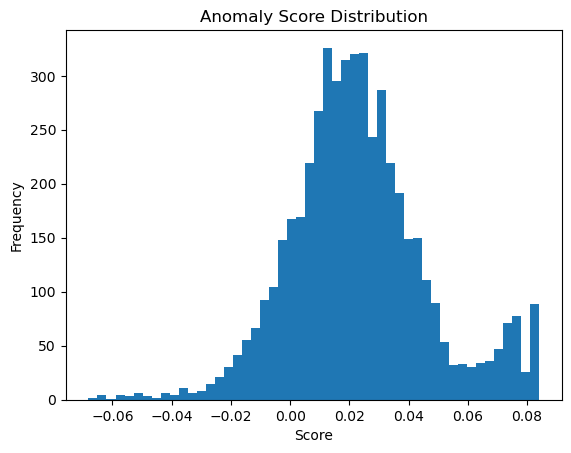

In [68]:
show_anomaly_score_plot(anomaly_scores)